In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import sqlite3
import pickle
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SpatialDropout1D,MaxPool1D
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kumarsanjeev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
path= "/Users/KumarSanjeev/Desktop/Training Data/stack-overflow-data.csv"

In [4]:
import pandas as pd
data=pd.read_csv(path,encoding='latin-1')

In [5]:
data["tags"].value_counts().sum

<bound method Series.sum of ios              2000
python           2000
iphone           2000
css              2000
android          2000
mysql            2000
objective-c      2000
angularjs        2000
javascript       2000
ruby-on-rails    2000
java             2000
php              2000
jquery           2000
sql              2000
c                2000
html             2000
.net             2000
asp.net          2000
c#               2000
c++              2000
Name: tags, dtype: int64>

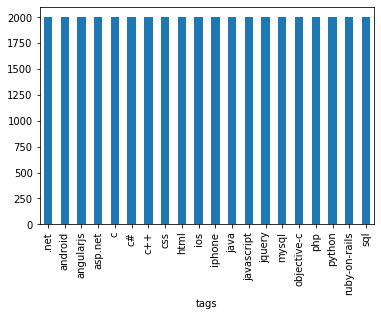

In [6]:
data.groupby("tags").post.count().plot.bar(ylim=0)

plt.show()


In [7]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 154810 unique tokens.


In [9]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(data['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (40000, 250)


In [10]:
Y = pd.get_dummies(data['tags']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (40000, 20)


In [11]:
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(36000, 250) (36000, 20)
(4000, 250) (4000, 20)


# # Option1

In [117]:
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(20, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Option2

In [16]:
import keras
embedding_dim = 100

model = Sequential()
#model.add(keras.layers.Embedding(input_dim=max_words, output_dim=100, input_length=max_len))
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.Conv1D(128, 5, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(20, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 128)          64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                1020      
Total params: 1,071,598
Trainable params: 1,071,598
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 32400 samples, validate on 3600 samples
Epoch 1/5
32400/32400 [==============================] - 42s 1ms/step - loss: 1.3016 - acc: 0.6260 - val_loss: 0.6591 - val_acc: 0.7864
Epoch 2/5
32400/32400 [==============================] - 42s 1ms/step - loss: 0.5099 - acc: 0.8349 - val_loss: 0.5863 - val_acc: 0.8108
Epoch 3/5
32400/32400 [==============================] - 42s 1ms/step - loss: 0.3453 - acc: 0.8905 - val_loss: 0.6068 - val_acc: 0.8042
Epoch 4/5
32400/32400 [==============================] - 40s 1ms/step - loss: 0.2113 - acc: 0.9363 - val_loss: 0.6445 - val_acc: 0.8008
Epoch 5/5
 8960/32400 [=======>......................] - ETA: 28s - loss: 0.1065 - acc: 0.9765

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))